# Simulating numerical Survival Data

In [4]:
%load_ext autoreload
%autoreload 2

In [145]:
import os
import plotly
from plotly import tools
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## 1. We begin by explicitly modeling a Multivariate Hazard Function:

In [142]:
# Covariates range [ 0 ; 1 ]
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
XX, YY = np.meshgrid(X, Y)

# Monotonic and Non-Monotonic hazards:
H1 = 3*(XX**2 - 0.5*YY**2)
H2 = 3*(XX**2 + 0.5*(2*YY-1)**2)

Visualize hazard surfaces side-by-side. Check this __[online surface plotter](https://academo.org/demos/3d-surface-plotter/)__ to visualize the risk in 3D.

In [143]:
h1_trace = go.Contour( x=X, y=Y, z=H1 )
h2_trace = go.Contour( x=X, y=Y, z=H2 )

fig = tools.make_subplots(rows=1, cols=2, print_grid=False,
    subplot_titles=('Monotnic Hazard', 'Non-Monotnic Hazard') )

fig.append_trace(h1_trace, 1, 1)
fig.append_trace(h2_trace, 1, 2)
fig['layout'].update(height=370, width=670)
py.iplot(fig, show_link=False)

## 2. Generate Survival Data according to the Hazard shape:

We need to produce samples such that individual hazards follow the two functions defined above. Let's generate two sets of hazards for the same set of covariates. Each set depends only on the first two covariates out of ***NC*** and the rest can either be considered as noise or just dropped.

In [381]:
# Parameters:
NS, NC    = 1000, 3

# Xs: Covariates sampled from uniform distribution in the range [0,1]
Xs = np.random.uniform(low=0, high=1, size=(NS, NC)).astype('float64')

# Hs: hazards as functions of (2/NC) covariates:
x1, x2 = Xs[:,0], Xs[:,1]
h1 = 5*(x1**2 - 0.5*x2**2)
h2 = 5*(x1**2 + 0.5*(2*x2-1)**2)

# Normalize risk scores:
h1 = (h1 - np.mean(h1)) / np.std(h1)
h2 = (h2 - np.mean(h2)) / np.std(h2)

Now time-to-event duration and event indicator tuples *( T, E )* can be generated based on hazards. We generate time durations from Exponential distribution. For more details see __[this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3546387/)__.

In [382]:
# Parameters:
censor_rate        = 0.15 # percentage
mean_surv_time     = 300  # in weeks may be
max_observ_period  = 1200 # in weeks may be

In [383]:
def time_to_event(risk, mean_t, max_t, c_rate):
    n_s = risk.shape[0]
    #  1 / lambda = mean time [ only for exponential! ]
    lmb = 1.0 / mean_t

    failure_times = np.zeros((n_s), dtype='float64')
    censoring     = np.zeros((n_s), dtype='int8')
    U = np.random.uniform(low=0, high=1, size=n_s)
    for i in range( n_s ):
        failure_times[i]  = -( (np.log(U[i])) / (lmb * np.exp(risk[i])) )
        censoring[i]      = np.random.binomial(1, (1-censor_rate), 1)
    
    # Falure times should be integers:
    failure_times = np.round(failure_times).astype('int64')

    # Apply non-informative right-cencoring: [ 0: censored 1: uncensored ]
    observed_times  = np.copy(failure_times)
    observed_times[ failure_times > max_observ_period ] = max_observ_period
    censoring[ failure_times > max_observ_period ] = 0
    
    return { 't': observed_times, 'e'  : censoring }

In [384]:
surv_tpl_h1 = time_to_event(h1, mean_surv_time, max_observ_period, censor_rate)
surv_tpl_h2 = time_to_event(h2, mean_surv_time, max_observ_period, censor_rate)

## 4. Combine data & prepare supplementary columns:

This is to prepare auxilary covariates ( **ft1**, **ft2** ) that will serve as features to generate synthetic images down the line. Essentially, we are rescaling **x1** and **x2** to a different range.

In [385]:
# OldRange = (OldMax - OldMin)
OldRange = ( 1 - 0 )

# NewRange = (NewMax - NewMin)  
x1Range = (30 - 0)  
x2Range = (200 - 0)

# NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
ft1 = np.round( (((x1-0) * x1Range) / OldRange) ).astype('int64')
ft2 = np.round( (((x2-0) * x2Range) / OldRange) ).astype('int64')

Also, we are going to need a binary indicator for each sample, i.e. **high (1) or low (0) risk** label:

In [386]:
bin_h1 = (h1 > np.median(h1)).astype('int8')
bin_h2 = (h2 > np.median(h2)).astype('int8')

Finally, let's put everything together into a data-frame:

In [387]:
# Covariates:
surv_df = pd.DataFrame(Xs)
surv_df.columns = ['x%d' % i for i in range(1,NC+1)]

# Hazards:
surv_df['h1'] = h1
surv_df['h2'] = h2

# Time-to-event:
surv_df['t1'] = surv_tpl_h1['t']
surv_df['e1'] = surv_tpl_h1['e']
surv_df['t2'] = surv_tpl_h2['t']
surv_df['e2'] = surv_tpl_h2['e']

# Binary labels:
surv_df['bin1'] = bin_h1
surv_df['bin2'] = bin_h2

Save to csv-file:

In [388]:
surv_df.to_csv('simulated_data/survival_data.csv', index=False)

## Visualize & validate:

In [389]:
surv_df.head(5)

,x1,x2,x3,h1,h2,t1,e1,t2,e2,bin1,bin2
0,0.067339,0.878000,0.487453,-1.609726,-0.612059,90,1,1200,0,0,0
1,0.449358,0.504344,0.775320,-0.236387,-0.881074,466,1,434,0,0,0
2,0.475155,0.095255,0.243893,0.205151,0.189139,156,1,65,0,1,1
3,0.778023,0.064209,0.931560,1.356581,1.503843,112,1,135,1,1,1
4,0.754886,0.198470,0.726064,1.196536,0.792944,196,1,7,1,1,1


In [390]:
surv_df.describe()

,x1,x2,x3,h1,h2,t1,e1,t2,e2,bin1,bin2
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000
mean,0.493454,0.518778,0.482481,-3.197442e-17,-7.371881e-17,351.242000,0.767000,360.507000,0.777000,0.50000,0.50000
std,0.291367,0.284998,0.290714,1.000500e+00,1.000500e+00,380.764527,0.422954,383.895412,0.416467,0.50025,0.50025
min,0.000661,0.002748,0.000644,-1.916766e+00,-1.495525e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.243922,0.280987,0.221240,-7.295958e-01,-8.176388e-01,64.000000,1.000000,59.000000,1.000000,0.00000,0.00000
50%,0.492186,0.522581,0.484078,-1.968789e-01,-1.810025e-01,184.000000,1.000000,192.000000,1.000000,0.50000,0.50000
75%,0.756780,0.763774,0.738121,6.969372e-01,7.362045e-01,503.500000,1.000000,552.000000,1.000000,1.00000,1.00000
max,0.997344,0.998732,0.998753,2.532038e+00,2.879450e+00,1200.000000,1.000000,1200.000000,1.000000,1.00000,1.00000


Covariates on scatter: color - hazard; shape - label

In [520]:
h10_trace = go.Scatter(
    x = surv_df.loc[surv_df['bin1'] == 0]['x1'], y = surv_df.loc[surv_df['bin1'] == 0]['x2'],
    name = 'Low risk', mode = 'markers',
    marker = dict(symbol = 125, size = 5, color = surv_df.loc[surv_df['bin1'] == 0]['h1'],
        colorscale='RdBu', cmax=surv_df['h1'].max(), cmin=surv_df['h1'].min(), showscale=False)
)
h11_trace = go.Scatter(
    x = surv_df.loc[surv_df['bin1'] == 1]['x1'], y = surv_df.loc[surv_df['bin1'] == 1]['x2'],
    name = 'High risk', mode = 'markers',
    marker = dict(symbol = 204, size = 4, color = surv_df.loc[surv_df['bin1'] == 1]['h1'],
        colorscale='RdBu', cmax=surv_df['h1'].max(), cmin=surv_df['h1'].min(), showscale=False)
)

h20_trace = go.Scatter(
    x = surv_df.loc[surv_df['bin2'] == 0]['x1'], y = surv_df.loc[surv_df['bin2'] == 0]['x2'],
    name = 'Low risk', mode = 'markers',
    marker = dict(symbol = 125, size = 5, color = surv_df.loc[surv_df['bin2'] == 0]['h2'],
        colorscale='RdBu', cmax=surv_df['h2'].max(), cmin=surv_df['h2'].min(), showscale=False)
)

h21_trace = go.Scatter(
    x = surv_df.loc[surv_df['bin2'] == 1]['x1'], y = surv_df.loc[surv_df['bin2'] == 1]['x2'],
    name = 'High risk', mode = 'markers',
    marker = dict(symbol = 204, size = 4, color = surv_df.loc[surv_df['bin2'] == 1]['h2'],
        colorscale='RdBu', cmax=surv_df['h2'].max(), cmin=surv_df['h2'].min(), showscale=False)
)

In [522]:
fig = tools.make_subplots(rows=1, cols=2, print_grid=False,
    subplot_titles=('Monotnic Hazard', 'Non-Monotnic Hazard') )

fig.append_trace(h10_trace, 1, 1)
fig.append_trace(h11_trace, 1, 1)
fig.append_trace(h20_trace, 1, 2)
fig.append_trace(h21_trace, 1, 2)
fig['layout'].update(height=470, width=970)
py.iplot(fig, show_link=False)

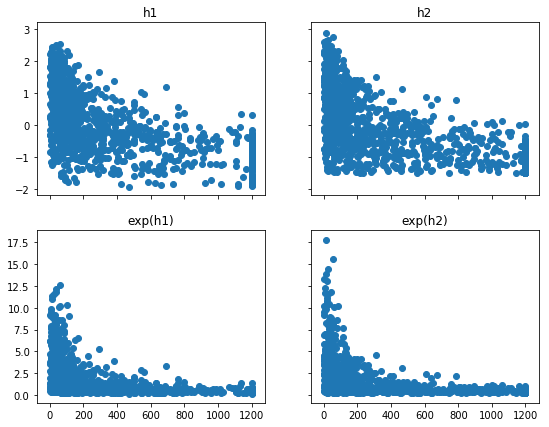

In [523]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(9,7))
ax1.scatter(surv_df['t1'], surv_df['h1']); ax1.set_title('h1');
ax2.scatter(surv_df['t2'], surv_df['h2']); ax2.set_title('h2');
ax3.scatter(surv_df['t1'], np.exp(surv_df['h1'])); ax3.set_title('exp(h1)');
ax4.scatter(surv_df['t2'], np.exp(surv_df['h2'])); ax4.set_title('exp(h2)');